<title>SPACESHIP TITANIC<title>
**EXPLORATORY DATA ANALYSIS**

## Índice

1. Introducción
2. Justificación del dataset elegido
3. Lectura del archivo y descripción del dataset
4. Selección de los datos de interés a analizar 
5. Limpieza de los datos

    5.1 Elementos nulos o vacíos
    
    5.2 Valores extremos

6. Análisis exploratorio

    6.1 Análisis descriptivo (gráficos y tal)
    
    6.2 Análisis estadístico
    
        - Comprobación de la normalidad y homogeneidad de la varianza
        - Aplicación de pruebas estadísticas (pone que al menos 3)

7. Conclusiones

# SPACESHIP TITANIC
## EXPLORATORY DATA ANALYSIS

1. Índice
1. Selección de los datos de interés a analizar
1. Lectura del archivo y descripción del dataset
1. Limpieza de los datos
    1. Elementos duplicados
    1. Elementos nulos o vacíos
    1. Valores extremos
1. Análisis exploratorio 
    1. Análisis descriptivo (gráficos y tal)
    1. Análisis estadístico
        1. Comprobación de la normalidad y homogeneidad de la varianza
        1. Aplicación de pruebas estadísticas (pone que al menos 3)
1. Conclusiones

# 1. Introducción 

El siguiente documento recoge la realización de la Práctica 2 de la asignatura Tipología y ciclo de vida de los datos. En ella se elabora un caso práctico orientado a aprender a identificar los datos relevantes para un proyecto analítico y usar las herramientas de integración, limpieza, validación y análisis de las mismas. En ella se pondrán en práctica los conceptos aprendidos durante todo el semestre de la asignatura, realizando un análisis exploratorio de un dataset seleccionado y aplicando técnicas de análisis de datos.

La práctica ha sido realizada por **Alicia Contreras** y **Daniel García**.

# 2. Selección de los datos de interés a analizar

El dataset elegido para esta práctica ha sido *Spaceship Titanic*. Se trata de una de las competiciones de la página web Kaggle.

https://www.kaggle.com/competitions/spaceship-titanic

Se ha elegido este conjunto de datos ya que cumple con las características esperadas para plantear con él una tarea de ciencia de datos. El dataset es facilmente accesible, ya que los datos pueden descargarse directamente desde la página web de Kaggle. La información acerca de las variables del dataset y del objetivo de la competición están explicados con detalle. La variabilidad de la información que tenemos (variables categóricas, numéricas y booleanas) nos ha permitido realizar un análisis exploratorio de los datos completo y en profundidad. Por último, la temática de la competición nos ha parecido interesante y el hecho de realizar el análisis exploratorio para esta práctica nos servirá para realizar los primeros pasos de cara a participar en la competición.


# 3. Lectura del archivo y descripción del dataset

A continuación se detalla el dataset de *Spaceship Titanic*. Se trata de una serie de datos de casi 13.000 pasajeros de una nave espacial en el año 2912, encargada de transportar emigrantes del sistema solar a tres exoplanetas habitables. Esta nave ha tenido un incidente por el cual gran parte de los pasajeros han sido enviados a otra dimensión.

El dataset contiene una variable objetivo que nos indica si un pasajero ha sido transportado a otra dimensión o no, con el objetivo de utilizar técnicas de ciencia de datos para predecirlo y evitar futuros desastres. 

Este dataset está compuesto por un total de 14 variables de las cuales encontramos

- Texto: 2 (una de ellas un identificador único de pasajero)
- Categóricas: 3
- Numéricas: 6
- Binarias: 3 (de las cuales una es la variable objetivo)

La descripción de estas variables se detalla a continuación.

- **PassengerId**: A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet**: The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep**: Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin**: The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination**: The planet the passenger will be debarking to.
- **Age**: The age of the passenger.
- **VIP**: Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**: Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name**: The first and last names of the passenger.
- **Transported**: Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



En la página fuente del dataset se proporcionan ya separados los datos de training y test. Sin embargo, de cara a realizar un EDA se realizará una unión de ambos subgrupos para formar un único dataset. Los datos del subconjunto de *test* no cuentan con información acerca de la variable objetivo por lo que aquellos análisis que incluyan la variable objetivo se realizarán únicamente en el conjunto de *training*.

In [2]:
titanic_train = pd.read_csv("data/train.csv")
titanic_test = pd.read_csv("data/test.csv")

titanic = pd.concat([titanic_train, titanic_test])

In [3]:
titanic.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Separamos las diferentes variables para futuros análisis

col_numeric = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
col_categoric = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
target = 'Transported'

titanic.shape

(12970, 14)

El datasete stá formado por un total de 12.970 registros y contiene 14 columnas. Queremos saber cuales de esas columnas tienen valores vacíos.

# 4. Limpieza de datos

En el siguiente apartado procederemos a realizar un análisis para ver si es necesario realizar una limpieza de datos.

## 4.1 Elementos duplicados

En primer lugar, comprobaremos si existen elementos duplicados en el dataset. Para ello utilizaremos la columna **PassengerId**. Se trata de un identificador único de cliente según las especificaciones del dataset. Vemos que esto se cumple, ya que no existe duplicidad en la columna. El resto de elementos del dataset si podrían estar duplicados por lo que con esta columna nos bastaría para ver que efectivamente, no existe duplicidad de registros.

In [5]:
titanic[titanic["PassengerId"].duplicated() == True].size

0

## 4.2 Valores extremos

A continuación queremos comprobar la existencia de valores extremos, ya que esto puede afectar en gran medida el análisis posterior.

<AxesSubplot:xlabel='VRDeck'>

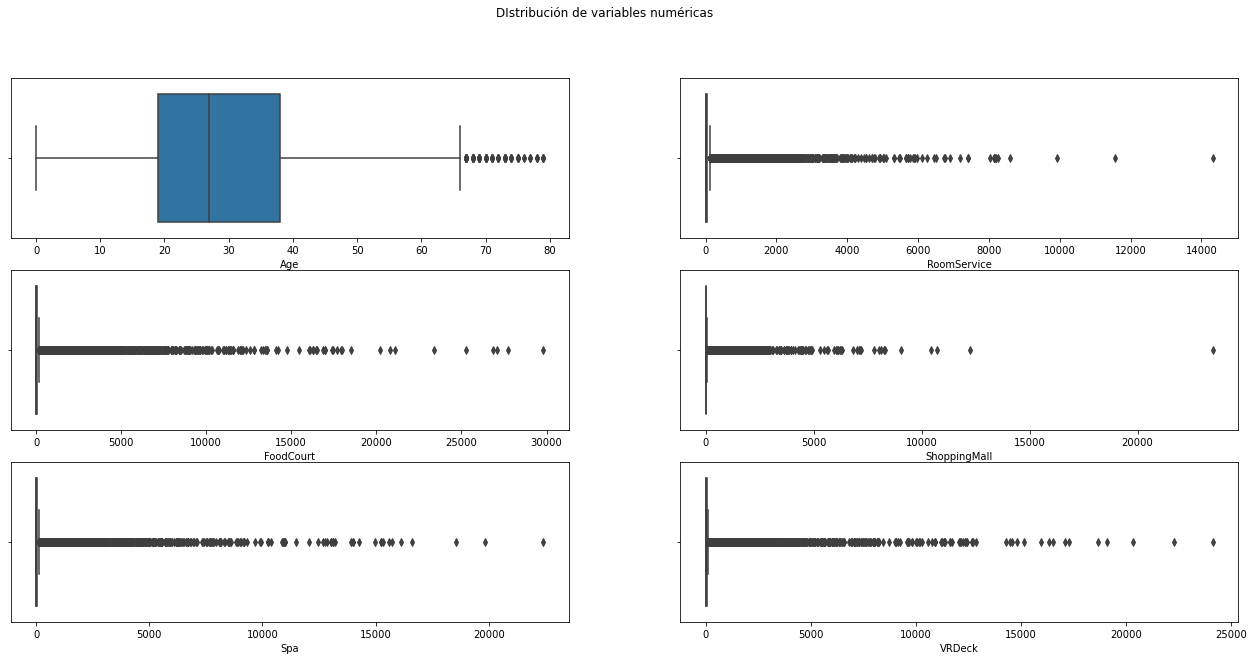

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(22, 10))

fig.suptitle('DIstribución de variables numéricas')


['Age''RoomService''FoodCourt''ShoppingMall''Spa''VRDeck']

sns.boxplot(ax=axes[0, 0], data=titanic, x='Age')
sns.boxplot(ax=axes[0, 1], data=titanic, x='RoomService')
sns.boxplot(ax=axes[1, 0], data=titanic, x='FoodCourt')
sns.boxplot(ax=axes[1, 1], data=titanic, x='ShoppingMall')
sns.boxplot(ax=axes[2, 0], data=titanic, x='Spa')
sns.boxplot(ax=axes[2, 1], data=titanic, x='VRDeck')

Tal y como podemos ver en la representación de los boxplots de las variables numéricas, existen gran cantidad de valores considerados *atípicos* en las relacionadas con las cantidades de dinero gastadas por los clientes. Podría considerarse eliminar los valores a partir de un rango, pero sin embargo, teniendo en cuenta el dominio del problema y al tratarse de cantidades monetarias se puede asumir que realmente hay clientes con mucho dinero que pueden asumir esa clase de gastos. En relación a la variable "age", los valores considerados atípicos en el boxplot están dentro del rango de edades posibles para una persona, por lo que los mantendremos. No se realizará por tanto ningún tratamiento extra de los valores atípicos.

on


## 4.3 Elementos nulos o vacíos

Finalizaremos por realizar un análisis sobre los elementos nulos existentes en el dataset, en qué medida afectan y si es necesario tratarlos.

In [7]:
titanic.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64

Por lo general parece que existe una gran cantidad de valores nulos en las columnas, a pesar de que no supone un número excesivamente alto con respecto al total de registros. Tal y como observamos a continuación, no hay muchas columnas con más de 3 valores nulos. 

In [8]:
titanic[titanic.isna().sum(axis=1) > 3]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
488,1050_01,NaN,True,G/157/P,TRAPPIST-1e,NaN,False,0.0,0.0,NaN,0.0,0.0,Evendy Buchansen,NaN
1192,2501_01,Europa,True,C/90/S,TRAPPIST-1e,47.0,False,0.0,NaN,NaN,0.0,0.0,NaN,NaN
2042,4412_01,Earth,False,F/907/P,NaN,19.0,NaN,9.0,3.0,0.0,1390.0,NaN,Roydo Mayson,NaN
3858,8435_01,NaN,NaN,F/1730/P,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,0.0,1216.0,NaN,NaN


Teniendo en cuenta las características del dataset, se han tomado las siguientes decisiones de diseño sobre el tratamiento de valores nulos:

- Los registros que no contengan la variable numérica **Age** se reemplazarán los valores nulos por la media de edad de todos los pasajeros de la nave.
- Las variables numéricas relacionadas con los gastos de los pasajeros en los dervicios de lujo de la nave **RoomService, FoodCourt, ShoppingMall, Spa y VRDeck** se sustituirán por $0$. Se asumirá que los clientes que no tengan información en estas variables es porque no se han gastado nada en ellos.
- Para las variables categóticas se mantendrán los nulos, ya que el hecho de que los valores estén a nulo puede ofrecernos información importante. En las variables no booleanas **HomePlanet**, **CryoSleep**, **Cabin** y **Destination** se sustituirán los nulos por la etiqueta "Desconocido".

In [9]:
# Sustituimos en la variable Age

titanic["Age"]=titanic["Age"].fillna(titanic["Age"].mean())

# En el resto de variables numéricas

titanic['RoomService']=titanic['RoomService'].fillna(0)
titanic['FoodCourt']=titanic['FoodCourt'].fillna(0)
titanic['ShoppingMall']=titanic['ShoppingMall'].fillna(0)
titanic['Spa']=titanic['Spa'].fillna(0)
titanic['VRDeck']=titanic['VRDeck'].fillna(0)

# Y finalmente en las variables categóricas

titanic['HomePlanet']=titanic['HomePlanet'].fillna("Desconocido")
titanic['CryoSleep']=titanic['CryoSleep'].fillna("Desconocido")
titanic['Cabin']=titanic['Cabin'].fillna("Desconocido")
titanic['Destination']=titanic['Destination'].fillna("Desconocido")



titanic.isna().sum()


PassengerId        0
HomePlanet         0
CryoSleep          0
Cabin              0
Destination        0
Age                0
VIP              296
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             294
Transported     4277
dtype: int64